# 1 Cell segmentation data
The class ”Data” in the main.py file will load the training and testing data. The get train image list and label list function will randomly sample an 300×300 image and the according 116 × 116 labels out of the training data images. We will use those samples to train the U-net. Since we will use a batchsize of 1, the function will put 1 image and its labels into the according lists. The get test image list and label list function will output a list with 12 new images (again with 300×300 resolution) and a list with the according labels (again with 116 × 116 resolution). Those images are not present in the training set. Use them for the validation accuracy of the network.

In [7]:
%matplotlib inline
import h5py
import numpy as np
import random
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
matplotlib.use('Agg')


class Data:
    def __init__(self):
        with h5py.File("cell_data.h5", "r") as data:
            self.train_images = [data["/train_image_{}".format(i)][:] for i in range(28)]
            self.train_labels = [data["/train_label_{}".format(i)][:] for i in range(28)]
            self.test_images = [data["/test_image_{}".format(i)][:] for i in range(3)]
            self.test_labels = [data["/test_label_{}".format(i)][:] for i in range(3)]

        self.input_resolution = 300
        self.label_resolution = 116

        self.offset = (300 - 116) // 2

    def get_train_image_list_and_label_list(self):
        n = random.randint(0, len(self.train_images) - 1)
        x = random.randint(0, (self.train_images[n].shape)[1] - self.input_resolution - 1)
        y = random.randint(0, (self.train_images[n].shape)[0] - self.input_resolution - 1)
        image = self.train_images[n][y:y + self.input_resolution, x:x + self.input_resolution, :]

        x += self.offset
        y += self.offset
        label = self.train_labels[n][y:y + self.label_resolution, x:x + self.label_resolution]

        return [image], [label]

    def get_test_image_list_and_label_list(self):
        coord_list = [[0, 0], [0, 116], [0, 232],
                      [116, 0], [116, 116], [116, 232],
                      [219, 0], [219, 116], [219, 232]]

        image_list = []
        label_list = []

        for image_id in range(3):
            for y, x in coord_list:
                image = self.test_images[image_id][y:y + self.input_resolution, x:x + self.input_resolution, :]
                image_list.append(image)
                x += self.offset
                y += self.offset
                label = self.test_labels[image_id][y:y + self.label_resolution, x:x + self.label_resolution]
                label_list.append(label)

        return image_list, label_list

# 2 U-net implementation
Implement the U-net with the architecture on slide 11 of the segmentation slides with the following reductions: Decrease the input resolution to 300×300 and use only half of the number of filters for each layer. Those reductions are necessary to fit the network on the available gpu memory of the computer pool.
Do not use any padding in all layers (⇔ use ’valid’ padding). If everything is implemented correctly the output resolution should be 116 × 116.
In tensorflow you can get the shape of each tensor using:
tensor.get shape().as list(). Use it to crop the filters to the according dimension during the ”Reusing Features” part of the network. You can use tf.concat to combine the cropped features with the new features.
Each convolution layer uses [3 × 3] filters with stride 1 and the output con- volution uses a [1 × 1] filter with stride 1. Each max pooling or transposed convolution layer uses a pooling or filter size of [2 × 2] and a stride of 2. We use a ReLu nonlinearity after each convolutional layer except for output layer.
For the weight tensor initialization use the tensorflow default initializer: tf.glorot uniform initializer(). It will be automatically selected if the initializer is set to None. For the bias vector use the 0 initialization: tf.zeros initializer().

In [8]:
def crop_concat(var1, var2):
    var2_rows = var2.get_shape().as_list()[1]
    var2_columns = var2.get_shape().as_list()[2]
    var1_crop = tf.image.resize_image_with_crop_or_pad(var1, var2_rows, var2_columns)
    return tf.concat([var1_crop, var2], 3) 
    
def network_prediction(x):
    x_image = tf.reshape(x, [-1, 300, 300, 1])
    conv1 = tf.layers.conv2d(x_image, filters=32, kernel_size=(3,3), strides=(1,1), 
                             padding='VALID', use_bias=True, activation=tf.nn.relu)
    conv2 = tf.layers.conv2d(conv1, filters=32, kernel_size=(3,3), strides=(1,1), 
                             padding='VALID', use_bias=True, activation=tf.nn.relu)
    
    maxpool1 = tf.layers.max_pooling2d(conv2, pool_size=(2,2), strides=(2,2))
    
    conv3 = tf.layers.conv2d(maxpool1, filters=64, kernel_size=(3,3), strides=(1,1),
                             padding='VALID', use_bias=True, activation=tf.nn.relu)
    conv4 = tf.layers.conv2d(conv3, filters=64, kernel_size=(3,3), 
                             strides=(1,1), padding='VALID', use_bias=True, activation=tf.nn.relu)
    
    maxpool2 = tf.layers.max_pooling2d(conv4, pool_size=(2,2), strides=(2,2))
    
    conv5 = tf.layers.conv2d(maxpool2, filters=128, kernel_size=(3,3),
                             strides=(1,1), padding='VALID', use_bias=True, activation=tf.nn.relu)
    conv6 = tf.layers.conv2d(conv5, filters=128, kernel_size=(3,3), 
                             strides=(1,1), padding='VALID', use_bias=True, activation=tf.nn.relu)
    
    maxpool3 = tf.layers.max_pooling2d(conv6, pool_size=(2,2), strides=(2,2))
    
    conv7 = tf.layers.conv2d(maxpool3, filters=256, kernel_size=(3,3),
                             strides=(1,1), padding='VALID', use_bias=True, activation=tf.nn.relu)
    conv8 = tf.layers.conv2d(conv7, filters=256, kernel_size=(3,3), 
                             strides=(1,1), padding='VALID', use_bias=True, activation=tf.nn.relu)
    
    maxpool4 = tf.layers.max_pooling2d(conv8, pool_size=(2,2), strides=(2,2))
    
    conv9 = tf.layers.conv2d(maxpool4, filters=512, kernel_size=(3,3),
                             strides=(1,1), padding='VALID', use_bias=True, activation=tf.nn.relu)
    conv10 = tf.layers.conv2d(conv9, filters=512, kernel_size=(3,3),
                              strides=(1,1), padding='VALID', use_bias=True, activation=tf.nn.relu)
    
    conv2d_transpose1 = tf.layers.conv2d_transpose(conv10, filters=256, kernel_size=(2, 2), padding='VALID', strides=2)
    
    conv2d_transpose1_concat = crop_concat(conv8, conv2d_transpose1)    
    conv11 = tf.layers.conv2d(conv2d_transpose1_concat, filters=256,
                              kernel_size=(3,3), strides=(1,1), padding='VALID', use_bias=True, activation=tf.nn.relu)
    conv12 = tf.layers.conv2d(conv11, filters=256, kernel_size=(3,3),
                              strides=(1,1), padding='VALID', use_bias=True, activation=tf.nn.relu)
    
    conv2d_transpose2 = tf.layers.conv2d_transpose(conv12, filters=128,
                                                   kernel_size=(2, 2), padding='VALID', strides=2)
    conv2d_transpose2_concat = crop_concat(conv6, conv2d_transpose2)
    
    conv13 = tf.layers.conv2d(conv2d_transpose2_concat, filters=128, 
                              kernel_size=(3,3), strides=(1,1), padding='VALID', use_bias=True, activation=tf.nn.relu)
    conv14 = tf.layers.conv2d(conv13, filters=128, kernel_size=(3,3), 
                              strides=(1,1), padding='VALID', use_bias=True, activation=tf.nn.relu)
    
    conv2d_transpose3 = tf.layers.conv2d_transpose(conv14, filters=64, 
                                                   kernel_size=(2, 2), padding='VALID', strides=2)
    conv2d_transpose3_concat = crop_concat(conv4, conv2d_transpose3)
    
    conv15 = tf.layers.conv2d(conv2d_transpose3_concat, filters=64, 
                              kernel_size=(3,3), strides=(1,1), padding='VALID', use_bias=True, activation=tf.nn.relu)
    conv16 = tf.layers.conv2d(conv15, filters=64, kernel_size=(3,3), 
                              strides=(1,1), padding='VALID', use_bias=True, activation=tf.nn.relu)
    
    conv2d_transpose4 = tf.layers.conv2d_transpose(conv16, filters=32, 
                                                   kernel_size=(2, 2), padding='VALID', strides=2)
    conv2d_transpose4_concat = crop_concat(conv2, conv2d_transpose4)
    
    conv17 = tf.layers.conv2d(conv2d_transpose4_concat, filters=32, 
                              kernel_size=(3,3), strides=(1,1), padding='VALID', use_bias=True, activation=tf.nn.relu)
    conv18 = tf.layers.conv2d(conv17, filters=32, kernel_size=(3,3), 
                              strides=(1,1), padding='VALID', use_bias=True, activation=tf.nn.relu)
    
    output = tf.layers.conv2d(conv18, filters=2, kernel_size=(1,1), 
                              strides=(1,1), padding='VALID', use_bias=True)
    return output


def learning_curves_plot(training_accuracy, test_accuracy):
    plt.plot(range(1,len(training_accuracy) + 1), training_accuracy, label='Training Accuracy')
    plt.plot(range(1,len(test_accuracy) + 1), test_accuracy, label='Validation Accuracy')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
    plt.xlabel('Number of Iterations')
    plt.ylabel('Accuracy')
    plt.savefig('learning_curve.png', bbox_inches='tight')
    plt.show()


def accuracy_plot(y_predict, y_):
    network_prediction = np.argmax(y_predict, axis=3)
    incorrect_pixel = np.sum(network_prediction != y_)
    correct_pixel = np.sum(network_prediction == y_)
    value_segmentation_accuracy = correct_pixel / (correct_pixel + 2 * incorrect_pixel)
    return value_segmentation_accuracy


def loss_plot(loss):
    plt.plot(range(1,len(loss) + 1), loss)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
    plt.xlabel('Number of Iterations')
    plt.ylabel('Training Loss')
    plt.savefig('loss.png')
    plt.show()
    

def images_plot(original_image, given_image,  predicted_image, i):
    fig = plt.figure()
    a=fig.add_subplot(3,1,1)
    plt.axis('off')
    imgplot = plt.imshow(original_image.squeeze(),cmap='gray')
    a.set_title('Original Image')
    a=fig.add_subplot(3,1,2)
    plt.axis('off')
    imgplot = plt.imshow(given_image.squeeze(),cmap='gray')
    a.set_title('Given Segmentation')
    a=fig.add_subplot(3,1,3)
    imgplot = plt.imshow(predicted_image.squeeze(),cmap='gray')
    a.set_title('Predicted Segmentation')
    plt.axis('off')
    plt.savefig('image_%s.png' % (i))
    plt.show()

# 3 Training of the Autoencoder
Implement the U-net with the architecture on slide 11 of the segmentation slides with the following reductions: Decrease the input resolution to 300×300 and use only half of the number of filters for each layer. Those reductions are necessary to fit the network on the available gpu memory of the computer pool.
Do not use any padding in all layers (⇔ use ’valid’ padding). If everything is implemented correctly the output resolution should be 116 × 116.
In tensorflow you can get the shape of each tensor using:
tensor.get shape().as list(). Use it to crop the filters to the according dimension during the ”Reusing Features” part of the network. You can use tf.concat to combine the cropped features with the new features.
Each convolution layer uses [3 × 3] filters with stride 1 and the output con- volution uses a [1 × 1] filter with stride 1. Each max pooling or transposed convolution layer uses a pooling or filter size of [2 × 2] and a stride of 2. We use a ReLu nonlinearity after each convolutional layer except for output layer.
For the weight tensor initialization use the tensorflow default initializer: tf.glorot uniform initializer(). It will be automatically selected if the initializer is set to None. For the bias vector use the 0 initialization: tf.zeros initializer().

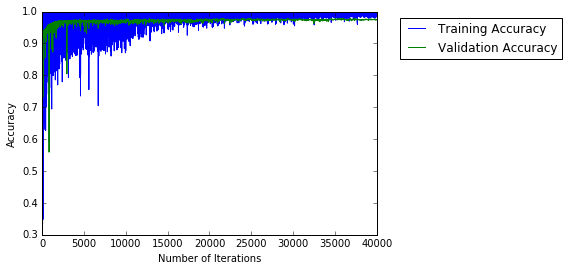

/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


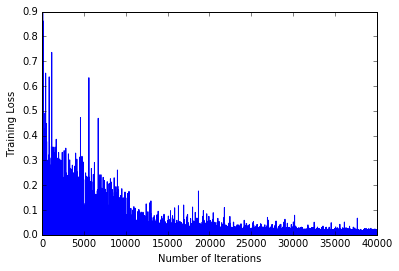

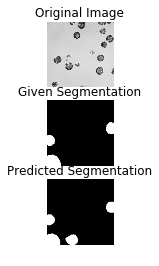

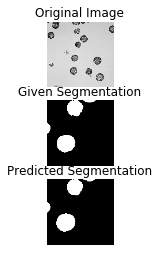

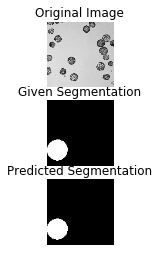

In [9]:
def train_u_net(d):
    X = tf.placeholder(tf.float32, [None, 300, 300, 1])
    Y = tf.placeholder(tf.int32, [None, 116, 116])
    y_predict = network_prediction(X)
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=Y, logits=y_predict))
    train_step = tf.train.AdamOptimizer(0.0001, 0.95, 0.99).minimize(loss)
    loss_list = list()
    training_accuracy = list()
    test_accuracy = list()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(40000):
            train_batch_xs, train_batch_ys = d.get_train_image_list_and_label_list()
            test_batch_xs, test_batch_ys = d.get_test_image_list_and_label_list()
            output_train, _, batch_loss = sess.run([y_predict, train_step, loss],feed_dict={X: train_batch_xs, Y:train_batch_ys})
            output_train, batch_loss = sess.run([y_predict, loss],feed_dict={X: train_batch_xs, Y:train_batch_ys})
            output_test = sess.run(y_predict,feed_dict={X: test_batch_xs, Y:train_batch_ys})
            training_accuracy.append(get_accuracy(output_train, train_batch_ys))
            test_accuracy.append(get_accuracy(output_test, test_batch_ys))             
            loss_list.append(batch_loss)
        
        learning_curves_plot(training_accuracy, test_accuracy)
        loss_plot(loss_list)
        test_batch_xs, test_batch_ys = d.get_test_image_list_and_label_list()
        
        for i in range(3):
            original_image = np.array(test_batch_xs)[i,:,:]
            given_image = np.array(test_batch_ys)[i,:,:]
            prediction = sess.run(y_predict, feed_dict={x: test_batch_xs})
            predicted_image = np.argmax(prediction, axis=3)
            plot_images(original_image, given_image, predicted_image[i], i)

if __name__ == "__main__":
    data = Data()
    train_u_net(data)